<a href="https://colab.research.google.com/github/Hramchenko/Handwritting/blob/master/YYYY_unif_Fin_V11_of_EQ_no_prof_simpl_new_proffs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
print("Device " + torch.cuda.get_device_name(0))
device = torch.device("cuda:0")
#device = torch.device("cpu")
print(device)

Device Tesla K80
cuda:0


In [0]:
batch_size = 100

image_width = 1000
image_height = 200

In [0]:
import os
import cv2
from xml.dom import minidom
import matplotlib.pyplot as plt
from math import floor
from random import random
import scipy as sp
import torch
import torch.nn as nn
import torch.nn.functional as F
        

In [4]:
import sys
sys.path.append("./Handwritting/")
from IAMWords import IAMWords


pad_length=-1
train_set = IAMWords("train", "./IAM/", batch_size=batch_size, line_height=image_height, line_width=image_width, scale=1, pad_length=pad_length, rand_x=20)
test_set = IAMWords("test", "./IAM/", batch_size=batch_size, line_height=image_height, line_width=image_width, scale=1, pad_length=pad_length, rand_x=20)

Reading ./IAM/words.train.pkl...
Reading finished
Reading ./IAM/words.test.pkl...
Reading finished


In [5]:
from ArtificialHandwritting import ArtificialHandwritting
artificial_data = ArtificialHandwritting(batch_size, "./MyLetters/", 1.0, image_width, image_height, train_set.encode_word)
data, target = artificial_data.make_random_batch(3, 400)

./MyLetters/a01-107u.xml
./MyLetters/a01-107u.png
./MyLetters/a01-107.xml
./MyLetters/a01-107.png
./MyLetters/a01-053u.xml
./MyLetters/a01-053u.png
./MyLetters/my.xml
./MyLetters/my.jpg
./MyLetters/a01-026u.xml
./MyLetters/a01-026u.png
./MyLetters/a01-128.xml
./MyLetters/a01-128.png


In [6]:
artificial_data.data["my.jpg"].keys()

dict_keys(['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 'u', 't', 'v', 'w', 'x', 'y', 'z', 'j'])

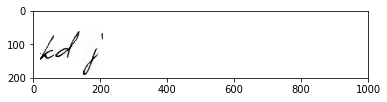

torch.Size([100, 200, 1000])

In [7]:
plt.imshow(data[0], cmap="gray")
plt.show()
data.shape

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from IPython.core.debugger import set_trace
%matplotlib inline
import matplotlib.pyplot as plt

In [0]:
#!cat ./Handwritting/HTRDecoder.py


In [0]:
from Layers import *
#from HTREncoder import *
#from HTRDecoder import *
from HTRDiscriminator import *

In [0]:
batch = train_set.make_batch(use_binarization=False)
data, target = batch
target = target.to(device)
data = data/255.0
data = data.unsqueeze(1).to(device)

In [0]:
class HTREncoder(nn.Module):
    def __init__(self, batchnorm=True, dropout=False):
        super(HTREncoder, self).__init__()
        
        self.convolutions = nn.Sequential(
        ConvLayer([1, 4, 3], padding=0, stride=2, bn=batchnorm, pool_layer=None),
        ConvLayer([4, 16, 3], padding=0, stride=2, bn=batchnorm, pool_layer=None),
        ConvLayer([16, 32, 3], padding=0, stride=2, bn=batchnorm, pool_layer=None),
        ConvLayer([32, 64, 3], padding=0, stride=1, bn=batchnorm, pool_layer=None))
#        ConvLayer([64, 64, (3, 1)], padding=0, stride=(3, 1), bn=batchnorm, pool_layer=None),
#        ConvLayer([64, 64, (3, 1)], padding=0, stride=(3, 1), bn=batchnorm, pool_layer=None))
        #self.fc = FullyConnectedX([64*15*49, 64*49*3, 64*49], activation_fn=nn.ReLU())
    
    def forward(self, x):
        h = self.convolutions(x)
        h = F.max_pool2d(h, [h.size(0), 1], padding=[0, 0])
        h = h.squeeze(2)
        #h = h.flatten(start_dim=1)
        #h = self.fc(h)
        #h = F.max_pool2d(h, [1, h.size(1)], padding=[0, 0])
        #h = h.permute([2, 3, 0, 1])[0]
        #h = h.permute([2, 3, 0, 1])
        return h

In [0]:
encoder = HTREncoder().to(device)

In [0]:
def restore_cnn(file_name):
  state = torch.load(file_name)
  encoder.load_state_dict(state["encoder"])
restore_cnn("/gdrive/My Drive/cnn.tar")

In [14]:
c = encoder(data)
c.shape

torch.Size([100, 64, 122])

In [0]:
class HTRDecoderResult:
  
  def __init__(self):
    None

class HTRDecoder(nn.Module):
    def __init__(self, batch_size, ntoken, encoded_width=122, encoded_height=64, batchnorm=False, dropout=True, rnn_type="LSTM"):
        super(HTRDecoder, self).__init__()
        self.batch_size = batch_size
        self.ntoken = ntoken
        self.encoded_width = encoded_width
        self.encoded_height = encoded_height
        self.lstm_size = 256
        self.lstm_layers = 2
        self.rnn_type = rnn_type
        self.emb_size = 128
        features_size = self.encoded_height*encoded_width + self.emb_size
        from math import floor
        lstm_inp_size = features_size
        
        if rnn_type == "LSTM":
            self.rnn = nn.LSTM(lstm_inp_size, self.lstm_size, self.lstm_layers, dropout=0.3, bidirectional=False)
        else:
            self.rnn = nn.GRU(lstm_inp_size, self.lstm_size, self.lstm_layers, dropout=0.3, bidirectional=False)
        self.embedding = nn.Embedding(ntoken, self.emb_size)
        self.inpBN = nn.BatchNorm1d(lstm_inp_size)
        self.decoder = nn.Linear(1*self.lstm_size*1, ntoken)#*batch_size)
        self.drop = nn.Dropout(0.3)
        self.attention_inp_size = self.lstm_size*2 + self.encoded_height*encoded_width
        self.attention1 = FullyConnectedX([self.attention_inp_size, floor(self.attention_inp_size*0.7)], activation_fn=nn.LeakyReLU(0.2), last_fn=nn.LeakyReLU(0.2))
        self.attention2 = FullyConnectedX([floor(self.attention_inp_size*0.7), floor(self.attention_inp_size*0.3),  self.encoded_width], activation_fn=nn.LeakyReLU(0.2), last_fn=nn.Tanh())
        self.attBN1 = nn.BatchNorm1d(self.attention_inp_size)
        self.attBN2 = nn.BatchNorm1d(floor(self.attention_inp_size*0.7))
        self.attention_weights = None
    
    def forward(self, x, prev, hidden=None):
        #x = self.drop(x).squeeze()
        x = x.squeeze()
        #print("xxxxxxxxxxxx")
        #print(x.shape)
        if hidden is not None:
            hidden_m = hidden.permute(1, 0, 2)
            hidden_m = hidden_m.flatten(start_dim=1)
            #print(x.shape)
            #print(hidden_m.shape)
            x_m = x.flatten(start_dim=1)
            attention_inp = torch.cat([x_m, hidden_m], dim=1).detach()
            #print(attention_inp.shape)
            #print(x.shape)
            attention_inp = self.attBN1(attention_inp)
            self.attention_weights = self.attention1(attention_inp)
            self.attention_weights = self.attBN2(self.attention_weights)
            self.attention_weights = self.attention2(self.attention_weights)
            self.attention_weights = F.softmax(self.attention_weights, dim=1).unsqueeze(1)
            #print("iiiif")
            #print(self.attention_weights.shape)
            
            self.attention_weights = self.attention_weights.repeat([1, self.encoded_height, 1])
            #print("fffff")
            #print(x.shape)
            #print(self.attention_weights.shape)
            x = x * self.attention_weights
        emb = self.embedding(prev).squeeze().detach()
        x = torch.cat([x.flatten(start_dim=1), emb], dim=1)
        #print(x.shape)
        x = self.inpBN(x)
        x = x.unsqueeze(0)
        result = HTRDecoderResult()
        result.rnn_input = x
        result.input_hidden = hidden
        x, hidden = self.rnn(x, hidden)
        x = x.squeeze(dim=0)
        #x = self.drop(x)
        x = self.decoder(x)
        x = F.log_softmax(x, dim=1)
        result.x = x
        result.hidden = hidden
        return result
      
    def makeHidden(self):
        if self.rnn_type == "LSTM":
            h1 = torch.zeros(self.lstm_layers, self.batch_size, self.lstm_size)
            h2 = torch.zeros(self.lstm_layers, self.batch_size, self.lstm_size)
            return (h1, h2)
        else:
            h1 = torch.zeros(self.lstm_layers, self.batch_size, self.lstm_size)
            return h1


decoder = HTRDecoder(batch_size, len(train_set.codes), rnn_type="GRU").to(device)

In [0]:
START = train_set.codes['<START>']
current_symbol = torch.LongTensor(batch_size, 1).to(device)
current_symbol[:, :] = START

In [0]:
def test(max_size, prob, randx):
  print("Testing...")
  
  freq = 20
  
  test_set.to_start(max_size, equalize_freq=True)
  batch_idx = 0
  c_loss = 0
  START = train_set.start_code
  STOP = train_set.stop_code
  recognition_result = torch.LongTensor(batch_size, 30+1).to(device)
  recognition_result.fill_(START)
  old_symbol = torch.LongTensor(batch_size, 1).to(device)
  
  stop_symbol = torch.LongTensor(batch_size, 1).to(device)
  stop_symbol.fill_(STOP)
  
  test_loss = 0
  
  with torch.no_grad():  
    while True:

      if random() <= prob:
        if (prob >= 1) and (batch_idx > 100):
          break
        l = 1 + floor(max_size*random())
        data, target = artificial_data.make_random_batch(l, randx)
        orig_data = data;
        data = data.unsqueeze(1).to(device)
        target = target.to(device)  
      else:  
        batch = test_set.make_batch()
        if batch is None:
          break
        orig_data, target = batch
        data = orig_data/255.0
        #data = data.view(batch_size, 1, image_width, image_height).to(device)
        data = data.unsqueeze(1).to(device)
        target = target.to(device)
      hidden = decoder.makeHidden().to(device)    
      loss = 0
      enc = encoder(data)
      s = enc
      s = s.detach()

      old_symbol[:, 0] = START
      for i in range(0, target.shape[1] + 1):
        decoder_result = decoder(s, old_symbol, hidden)
        dec = decoder_result.x
        hidden = decoder_result.hidden

        recognition_result[:, i] = dec.topk(1, dim=1)[1].flatten().detach()
        old_symbol[:, 0] = recognition_result[:, i]#target[:, i]
        k = 1
        if i == target.shape[1]:
          target_symbol = stop_symbol[:, 0]
          k = 1.5
        else:
          target_symbol = target[:, i]  
        loss += k*criterion(dec, target_symbol)
      c_loss += loss.item()/(target.shape[1] + 1)
      test_loss += loss.item()/(target.shape[1] + 1)
      if (batch_idx % freq == 0) and (batch_idx != 0):
        if True:#not use_teacher_forcing:
          print(target.shape[0])
          for k in range(0, min(3, target.shape[0])):
              decoded = recognition_result[k,0:target.shape[1] + 1]
              plt.imshow(orig_data[k].cpu(), cmap="gray")
              plt.show()
              print("  '" + train_set.decode_word(target[k,:]) + "' -> '" + train_set.decode_word(decoded) + "'")
        c_loss /= freq 
        print("  Batch: " + str(batch_idx) + " Loss: " + str(c_loss))
        c_loss = 0
      batch_idx += 1  
  print("Test loss: %f" % (test_loss/batch_idx))   

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from Layers import *

# Based on: https://github.com/aryopg/Professor_Forcing_Pytorch/blob/master/models/losses.py
class HTRDiscriminator(nn.Module):
    def __init__(self, batch_size, input_size, hidden_size, input_length, symbs_cnt):
        super(HTRDiscriminator, self).__init__()
        self.batch_size = batch_size
        self.embedding = nn.Embedding(symbs_cnt, 128)
        
        from math import floor
        #self.hidden_cells = 256
        #self.hidden_layers = 2
        
        self.hidden_size = hidden_size
        self.input_length = input_length
        self.rnn_layers = 1#2
        
        input_size = 8576
        gru_input_size = 512
        self.bn1 = nn.BatchNorm1d(input_size)
        self.enc = FullyConnectedX([input_size, floor(input_size*0.7), gru_input_size], activation_fn=nn.ReLU())
        self.bn2 = nn.BatchNorm1d(gru_input_size)
        self.batchnorm = nn.BatchNorm1d(gru_input_size)
        self.gru = nn.GRU(gru_input_size, hidden_size, self.rnn_layers)
        gru_out = hidden_size
        self.fc = FullyConnectedX([gru_out, floor(gru_out*0.7), floor(gru_out*0.3), 1], activation_fn=nn.ReLU())
        self.optimizer = optim.Adam(self.parameters(), lr=1e-4, weight_decay=0.00005)
        
    def zero_grad(self):
        self.optimizer.zero_grad()

    def apply(self, hidden, hidden_states, dec_inputs, dec_outputs, targets):
        emb_outputs = self.embedding(dec_outputs)#.permute(1, 0, 2)
        hidden_states = hidden_states.permute(1, 0, 2).flatten(start_dim=1)
        dec_inputs = dec_inputs.squeeze(0)
#         print(emb_outputs.shape)
#         print(hidden_states.shape)
#         print(dec_inputs.shape)
        full_input = torch.cat([hidden_states, dec_inputs, emb_outputs], dim=1)
        #print(full_input.shape)
        output = self.enc(full_input)
        output = self.bn2(output)
        output = output.unsqueeze(0)
        output, hidden = self.gru(output, hidden)
        output= output.squeeze(0)
        out = self.fc(output)
#         print(out.shape)
#         print(targets.shape)
        loss = F.binary_cross_entropy_with_logits(out, targets)
        return loss, hidden

    def makeHidden(self):
        return torch.zeros(self.rnn_layers, self.batch_size, self.hidden_size)
      
discriminator = HTRDiscriminator(batch_size, 256*2, 512, 10, len(train_set.codes)).to(device)       
discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=1e-4, weight_decay=0.00005)

In [0]:
def apply_discriminator(s, target, use_teacher_forcing, train_mode, discriminator_target):
  loss = 0
  START = train_set.start_code
  STOP = train_set.stop_code
  recognition_result = torch.LongTensor(batch_size, 30+1).to(device)
  old_symbol = torch.LongTensor(batch_size, 1).to(device)
  stop_symbol = torch.LongTensor(batch_size, 1).to(device)
  stop_symbol.fill_(STOP)
  old_symbol[:, 0] = START

  train_mask = torch.ByteTensor(batch_size).to(device)
  train_mask[:] = 1

  hidden = decoder.makeHidden().to(device)    
  discriminator_loss = 0
  discriminator_hidden = discriminator.makeHidden().to(device)

  discr_features = []
  for i in range(0, target.shape[1] + 1):

    decoder_result = decoder(s, old_symbol, hidden)
    dec = decoder_result.x
    hidden = decoder_result.hidden

    decoder_outputs = dec.topk(1, dim=1)[1].flatten()

    
    if train_mode:
      dl, discriminator_hidden = discriminator.apply(discriminator_hidden.detach(), decoder_result.input_hidden.detach(),decoder_result.rnn_input.detach(), decoder_outputs.detach(), discriminator_target)
    else:
      dl, discriminator_hidden = discriminator.apply(discriminator_hidden, decoder_result.input_hidden, decoder_result.rnn_input, decoder_outputs, discriminator_target)
    if i != 0:
      discriminator_loss += dl

    recognition_result[:, i] = decoder_outputs.detach()
    k = 1
    if i == target.shape[1]:
      target_symbol = stop_symbol[:, 0]
      k = 1.5
    else:
      target_symbol = target[:, i]    
    
    if use_teacher_forcing:
      old_symbol[:, 0] = target_symbol
    else:
      old_symbol[:, 0] = recognition_result[:, i]
    loss += criterion(dec, target_symbol)*k
 
  #discriminator_decision = discriminator.makeDecision(discr_features)
  #print("---------")
  #print(discriminator_decision[0:10])
  #print(discriminator_target[0:10])
  #discriminator_loss = F.binary_cross_entropy_with_logits(discriminator_decision, discriminator_target)

  discriminator_loss /= target.shape[1]
  return (recognition_result, loss, discriminator_loss)

In [0]:
def apply_decoder(s, target, use_teacher_forcing):
  loss = 0
  START = train_set.start_code
  STOP = train_set.stop_code
  recognition_result = torch.LongTensor(batch_size, 30+1).to(device)
  recognition_result.fill_(START)
  old_symbol = torch.LongTensor(batch_size, 1).to(device)
  stop_symbol = torch.LongTensor(batch_size, 1).to(device)
  stop_symbol.fill_(STOP)
  old_symbol[:, 0] = START

  hidden = decoder.makeHidden().to(device)  
  
  for i in range(0, target.shape[1] + 1):
    decoder_result = decoder(s, old_symbol, hidden)
    dec = decoder_result.x
    hidden = decoder_result.hidden

    recognition_result[:, i] = dec.topk(1, dim=1)[1].flatten().detach()
    
    k = 1
    if i == target.shape[1]:
      target_symbol = stop_symbol[:, 0]
      k = 1.5
    else:
      target_symbol = target[:, i]
    
    if use_teacher_forcing:
      old_symbol[:, 0] = target_symbol
    else:
      old_symbol[:, 0] = recognition_result[:, i]
    #import pdb; pdb.set_trace()

    loss += k*criterion(dec, target_symbol)
  return (recognition_result, loss)


batch_zeros = torch.zeros(batch_size, 1).to(device)
batch_ones = torch.ones(batch_size, 1).to(device)

In [0]:
#encoder_optimizer = optim.Adam(encoder.parameters(), lr=1e-4, weight_decay=0.00005)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=1e-4, weight_decay=0.00005)


In [0]:
encoder_optimizer = optim.Adam(encoder.parameters(), lr=1e-4, weight_decay=0.00005)

In [0]:

criterion = nn.NLLLoss()
#criterion = nn.CrossEntropyLoss()
from random import random

def train(epoch, max_size, apply_professor, prob, randx):
  print("Training epoch " + str(epoch) + "...")
  freq = 30
  train_set.to_start(max_size, equalize_freq=True)
  batch_idx = 0
  c_loss = 0
  train_loss = 0
  discr_applied = 0
  while True:
    if random() <= prob:
      if (prob >= 1) and (batch_idx > 400):
        break    
      l = 1 + floor(max_size*random())
      data, target = artificial_data.make_random_batch(l, randx)
      data = data.unsqueeze(1).to(device)
      target = target.to(device)
    else:
      batch = train_set.make_batch()
      if batch is None:
        break
      orig_data, target = batch
      data = orig_data/255.0
      data = data.unsqueeze(1).to(device)
      target = target.to(device)
    #encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
#     with torch.no_grad():
#       enc = encoder(data)
#       s = enc
#       s = s.unsqueeze(0)
#       s = s.detach()
    enc = encoder(data)
    s = enc
    s = s.unsqueeze(0)
      
    discr_loss = 1
    if apply_professor:
      discriminator_optimizer.zero_grad()
      det_s = s.detach()
      _, _, tf_loss = apply_discriminator(det_s, target, True, True, batch_ones)
      _, _, fr_loss = apply_discriminator(det_s, target, False, True, batch_zeros)
      dl = tf_loss + fr_loss
      discr_loss = dl.item()
      if (batch_idx % freq == 0) and (batch_idx != 0):
        print("Discr loss: %f" %(dl.item()))
      dl.backward()
      discriminator_optimizer.step()
    D_loss_curr = None
    batch_loss = None  
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    discriminator_optimizer.zero_grad()
    if apply_professor and (discr_loss < 0.2) and (discr_loss > 0.01):
      discriminator_optimizer.zero_grad()
      recognition_result, loss, discriminator_loss = apply_discriminator(s, target, True, False, batch_zeros)
      batch_loss = loss.item()
      loss = loss + discriminator_loss
      D_loss_curr = discriminator_loss.item()
      discr_applied += 1
    else:
      recognition_result, loss = apply_decoder(s, target, True)
      batch_loss = loss.item()
    c_loss += batch_loss/(target.shape[1] + 1)
    train_loss += batch_loss/(target.shape[1] + 1)
    if (batch_idx % freq == 0) and (batch_idx != 0):
      c_loss /= freq 
      print("  Batch: " + str(batch_idx) + " Loss: " + str(c_loss))
      c_loss = 0
    loss.backward()
    
    if False:#D_loss_curr is not None:
      _, _, D_loss_new = apply_discriminator(s, target, True, False, batch_zeros)
      print("old/new: %f / %f Batch %f" %(D_loss_curr, D_loss_new, batch_loss))
    #grad_clip = 0.1
    #torch.nn.utils.clip_grad_norm_(encoder.parameters(), grad_clip)
    #torch.nn.utils.clip_grad_norm_(decoder.parameters(), grad_clip)
    encoder_optimizer.step()
    decoder_optimizer.step()
    batch_idx += 1
  print("Train loss: %f"%(train_loss/batch_idx))
  print("Discr applied %d times."%discr_applied)



In [0]:
file_name = "/gdrive/My Drive/unif v9.tar"

In [0]:
# state = torch.load(file_name)
# encoder.load_state_dict(state["encoder"])
# encoder_optimizer.load_state_dict(state["encoder_optimizer"])
# decoder.load_state_dict(state["decoder"])
# decoder_optimizer.load_state_dict(state["decoder_optimizer"])
# discriminator.load_state_dict(state["discriminator"])
# discriminator_optimizer.load_state_dict(state["discriminator_optimizer"])

In [0]:
 def save_decoder(file_name):
  state_dict = {
        "decoder": decoder.state_dict(),
        "decoder_optimizer": decoder_optimizer.state_dict(),
      }

  torch.save(state_dict, file_name)
  print("Network saved: %s" %file_name)

In [0]:
# for i in range(0, 100):
#   max_size =3
#   prob = 1
#   randx = 750
#   train(i, max_size, False, prob, randx)
#   test(max_size, prob, randx)

In [0]:
decoder_file = "/gdrive/My Drive/decoder3.tar"
#save_decoder(decoder_file)

In [0]:
def restore_decoder(file_name):
  state = torch.load(file_name)
  decoder.load_state_dict(state["decoder"])
  decoder_optimizer.load_state_dict(state["decoder_optimizer"])


In [0]:
restore_decoder(decoder_file)

In [0]:
#save_net("/gdrive/My Drive/net3s.tar")

In [0]:
decoder8_file = "/gdrive/My Drive/decoder8.tar"

In [0]:
restore_decoder(decoder8_file)

In [0]:
# for i in range(0, 15):
#   max_size = 8
#   prob = 1
#   randx=20
#   train(i, max_size, False, prob, randx)
#   test(max_size, prob, randx)


In [0]:
#save_decoder(decoder8_file)

In [0]:
 def save_net(file_name):
  state_dict = {
        "encoder": encoder.state_dict(),
        "encoder_optimizer": encoder_optimizer.state_dict(),
        "decoder": decoder.state_dict(),
        "decoder_optimizer": decoder_optimizer.state_dict(),
        "discriminator": discriminator.state_dict(),
        "discriminator_optimizer": discriminator_optimizer.state_dict(),
      }

  torch.save(state_dict, file_name)
  print("Network saved: %s" %file_name)

In [0]:
 def save_decoder_and_discriminator(file_name):
  state_dict = {
        "decoder": decoder.state_dict(),
        "decoder_optimizer": decoder_optimizer.state_dict(),
        "discriminator": discriminator.state_dict(),
        "discriminator_optimizer": discriminator_optimizer.state_dict(),
      }

  torch.save(state_dict, file_name)
  print("Network saved: %s" %file_name)

In [0]:
def restore_decoder_and_discriminator(file_name):
  state = torch.load(file_name)
  decoder.load_state_dict(state["decoder"])
  decoder_optimizer.load_state_dict(state["decoder_optimizer"])
  discriminator.load_state_dict(state["discriminator"])
  discriminator_optimizer.load_state_dict(state["discriminator_optimizer"])

In [0]:

decoder_discr_8_file = "/gdrive/My Drive/decoder_discr_8.tar"
decoder_discr_8_2_file = "/gdrive/My Drive/decoder_discr_8_2.tar"
decoder_discr_8_cnn_file = "/gdrive/My Drive/decoder_discr_8_cnn.tar"

In [0]:
decoder_discr_8_iam_file = "/gdrive/My Drive/decoder_discr_8_iam.tar"
#save_decoder_and_discriminator(decoder_discr_8_iam_file)

In [46]:
#save_decoder_and_discriminator(decoder_discr_8_2_file)

Network saved: /gdrive/My Drive/decoder_discr_8_2.tar


In [58]:
#save_net(decoder_discr_8_cnn_file)

Network saved: /gdrive/My Drive/decoder_discr_8_cnn.tar


In [0]:
#restore_decoder_and_discriminator(decoder_discr_8_file)

In [0]:
#restore_decoder_and_discriminator(decoder_discr_8_2_file)

In [0]:
# for i in range(0, 15):
#   max_size = 8
#   prob = 1
#   randx=20
#   train(i, max_size, True, prob, randx)
#   test(max_size, prob, randx)
#   if i % 3 == 0:
#     save_decoder_and_discriminator(decoder_discr_8_file)

Training epoch 0...
  Batch: 30 Loss: 0.11308292631301338
  Batch: 60 Loss: 0.1456494415821458
  Batch: 90 Loss: 0.13520723028197174
  Batch: 120 Loss: 0.12391917838187759
  Batch: 150 Loss: 0.10174922463380628
  Batch: 180 Loss: 0.12699730873403567
  Batch: 210 Loss: 0.1346040039833773
  Batch: 240 Loss: 0.17557460127388513
  Batch: 270 Loss: 0.1101417351534797
  Batch: 300 Loss: 0.13340225814531248
  Batch: 330 Loss: 0.12660980779559367
  Batch: 360 Loss: 0.12731436508685529
  Batch: 390 Loss: 0.14682724012682835
  Batch: 420 Loss: 0.1628571682995944
  Batch: 450 Loss: 0.12201613678232269
  Batch: 480 Loss: 0.11010344826453736
  Batch: 510 Loss: 0.10614703055027697
  Batch: 540 Loss: 0.09299321320252837
  Batch: 570 Loss: 0.1307628214069539
  Batch: 600 Loss: 0.13183576486965337
  Batch: 630 Loss: 0.07725654889814673
Train loss: 0.125445
Discr applied 0 times.
Testing...
100


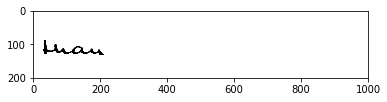

  'than' -> 'than<STOP>'


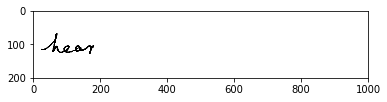

  'hear' -> 'hear<STOP>'


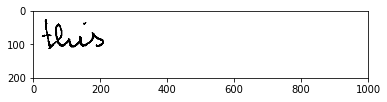

  'this' -> 'this<STOP>'
  Batch: 20 Loss: 0.6380052206215876
100


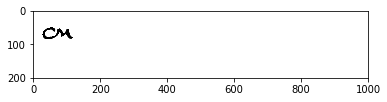

  'on' -> 'on<STOP>'


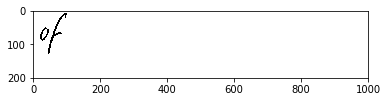

  'of' -> 'of<STOP>'


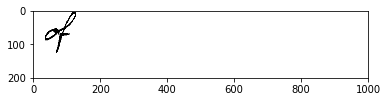

  'of' -> 'of<STOP>'
  Batch: 40 Loss: 0.32681866885088984
100


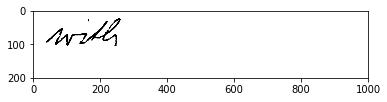

  'with' -> 'with<STOP>'


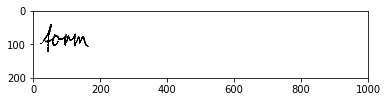

  'from' -> 'from<STOP>'


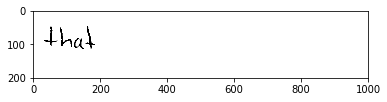

  'that' -> 'that<STOP>'
  Batch: 60 Loss: 0.7388722111408909
Test loss: 0.533964
Training epoch 1...
  Batch: 30 Loss: 0.15694124407893806
  Batch: 60 Loss: 0.13005155492711948
  Batch: 90 Loss: 0.10929271475648478
  Batch: 120 Loss: 0.1175468294817225
  Batch: 150 Loss: 0.16290128225096007
  Batch: 180 Loss: 0.12473575118204785
  Batch: 210 Loss: 0.14897011120877568
  Batch: 240 Loss: 0.1401351518128757
  Batch: 270 Loss: 0.11642382633561892
  Batch: 300 Loss: 0.15766692563240964
  Batch: 330 Loss: 0.1437529964523301
  Batch: 360 Loss: 0.1103997255906108
  Batch: 390 Loss: 0.07347288077490195
  Batch: 420 Loss: 0.14881050613147045
  Batch: 450 Loss: 0.11399210913481299
  Batch: 480 Loss: 0.1472819806499377
  Batch: 510 Loss: 0.101770910286793
  Batch: 540 Loss: 0.14119267917134695
  Batch: 570 Loss: 0.14027468739791954
  Batch: 600 Loss: 0.14394483141453254
  Batch: 630 Loss: 0.0945437547157484
Train loss: 0.128859
Discr applied 0 times.
Testing...
100


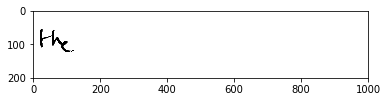

  'the' -> 'the<STOP>'


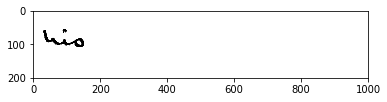

  'his' -> 'his<STOP>'


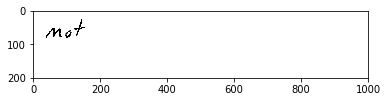

  'not' -> 'not<STOP>'
  Batch: 20 Loss: 0.6386472622987385
100


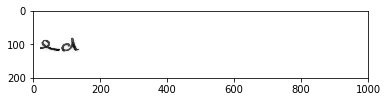

  'ed' -> 'ed<STOP>'


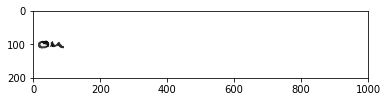

  'on' -> 'on<STOP>'


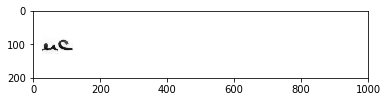

  'nc' -> 'nc<STOP>'
  Batch: 40 Loss: 0.6667714655630674
100


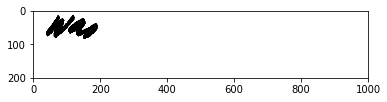

  'was' -> 'was<STOP>'


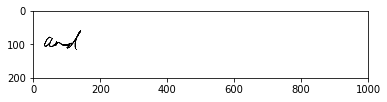

  'and' -> 'and<STOP>'


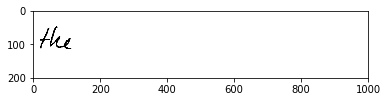

  'the' -> 'the<STOP>'
  Batch: 60 Loss: 0.39852582387714863
Test loss: 0.536536
Training epoch 2...
  Batch: 30 Loss: 0.13891711921081262
  Batch: 60 Loss: 0.13525791973939966
  Batch: 90 Loss: 0.1401876506060559
  Batch: 120 Loss: 0.1458562409578177
  Batch: 150 Loss: 0.13054175618691027
  Batch: 180 Loss: 0.13262476782615065
  Batch: 210 Loss: 0.12109521076339422
  Batch: 240 Loss: 0.10822814899748043
  Batch: 270 Loss: 0.13658681252133592
  Batch: 300 Loss: 0.15284083032620846
  Batch: 330 Loss: 0.08113873224705456
  Batch: 360 Loss: 0.11862374411378468
  Batch: 390 Loss: 0.12060119379558182
  Batch: 420 Loss: 0.11206160182244189
  Batch: 450 Loss: 0.12270676123668199
  Batch: 480 Loss: 0.08087976289270003
  Batch: 510 Loss: 0.12450490746923065
  Batch: 540 Loss: 0.1417621486004265
  Batch: 570 Loss: 0.095425314923364
  Batch: 600 Loss: 0.10268967215045695
  Batch: 630 Loss: 0.09879773580543105
Train loss: 0.119648
Discr applied 0 times.
Testing...
100


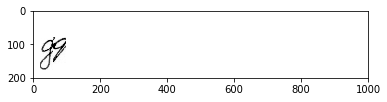

  'gq' -> 'gq<STOP>'


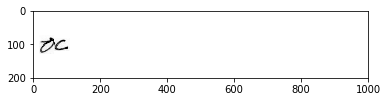

  'oc' -> 'oc<STOP>'


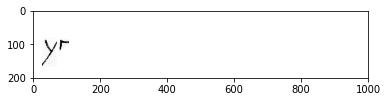

  'yr' -> 'yr<STOP>'
  Batch: 20 Loss: 0.5492616936963584
100


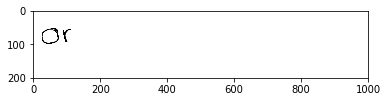

  'or' -> 'or<STOP>'


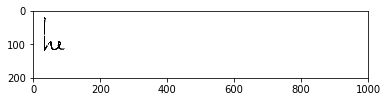

  'he' -> 'he<STOP>'


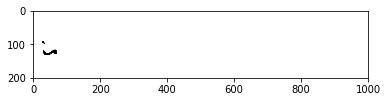

  'is' -> 'is<STOP>'
  Batch: 40 Loss: 0.7161140132343602
100


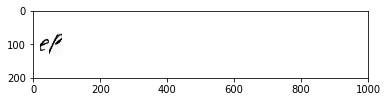

  'ep' -> 'ep<STOP>'


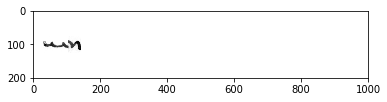

  'mn' -> 'mn<STOP>'


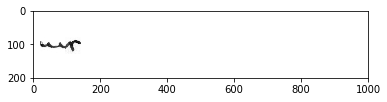

  'mr' -> 'mr<STOP>'
  Batch: 60 Loss: 0.5151760890722896
Test loss: 0.584908
Training epoch 3...
  Batch: 30 Loss: 0.13286823248618812
  Batch: 60 Loss: 0.10529619789711893
  Batch: 90 Loss: 0.14421012199106845
  Batch: 120 Loss: 0.13919132755566685
  Batch: 150 Loss: 0.12661593236699306
  Batch: 180 Loss: 0.10445561183192743
  Batch: 210 Loss: 0.13646434227152476
  Batch: 240 Loss: 0.12237032829788783
  Batch: 270 Loss: 0.11755863244832548
  Batch: 300 Loss: 0.11697403903518405
  Batch: 330 Loss: 0.1213986323583654
  Batch: 360 Loss: 0.14911465972681684
  Batch: 390 Loss: 0.12258932239834278
  Batch: 420 Loss: 0.10672737063734088
  Batch: 450 Loss: 0.1384849406845828
  Batch: 480 Loss: 0.14605945570601356
  Batch: 510 Loss: 0.08871144543815819
  Batch: 540 Loss: 0.12862330428452756
  Batch: 570 Loss: 0.10012720161704002
  Batch: 600 Loss: 0.11363254060377441
  Batch: 630 Loss: 0.1321187963892543
Train loss: 0.121773
Discr applied 0 times.
Testing...
100


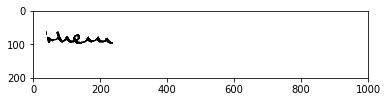

  'them' -> 'them<STOP>'


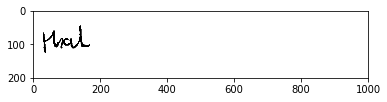

  'that' -> 'thew<STOP>'


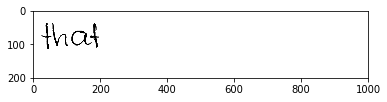

  'that' -> 'that<STOP>'
  Batch: 20 Loss: 0.7045656732397362
100


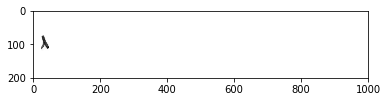

  'l' -> 'l<STOP>'


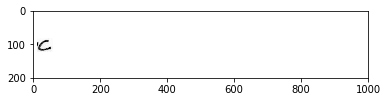

  'c' -> 'c<STOP>'


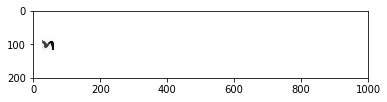

  'n' -> 'n<STOP>'
  Batch: 40 Loss: 0.5924606377281071
100


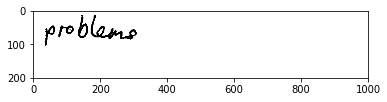

  'problems' -> 'problem<STOP><STOP>'


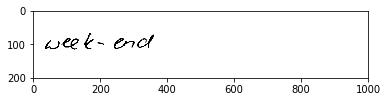

  'week-end' -> 'week-qe<STOP><STOP>'


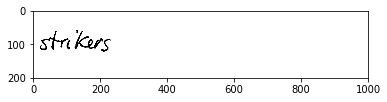

  'strikers' -> 'strikers<STOP>'
  Batch: 60 Loss: 0.745518168263019
Test loss: 0.649953
Training epoch 4...
  Batch: 30 Loss: 0.1398447371388554
  Batch: 60 Loss: 0.11932375481874538
  Batch: 90 Loss: 0.1265432547618236
  Batch: 120 Loss: 0.14958593495214778
  Batch: 150 Loss: 0.11128889416571133
  Batch: 180 Loss: 0.13288297163766052
  Batch: 210 Loss: 0.0712838412052582
  Batch: 240 Loss: 0.1186805608727915
  Batch: 270 Loss: 0.10097213826363995
  Batch: 300 Loss: 0.13028412924498003
  Batch: 330 Loss: 0.12102726281285481
  Batch: 360 Loss: 0.13338975546339515
  Batch: 390 Loss: 0.10630608459964158
  Batch: 420 Loss: 0.1394778875848919
  Batch: 450 Loss: 0.12750853097312664
  Batch: 480 Loss: 0.22934459361528595
  Batch: 510 Loss: 0.2559907856477159
  Batch: 540 Loss: 0.1617209661627809
  Batch: 570 Loss: 0.12507193333296865
  Batch: 600 Loss: 0.1194391812356534
  Batch: 630 Loss: 0.14602296498342954
  Batch: 660 Loss: 0.07456305495123304
Train loss: 0.133291
Discr applied 0 times.


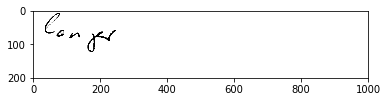

  'longer' -> 'lenger<STOP>'


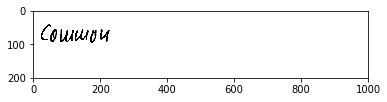

  'common' -> 'countr<STOP>'


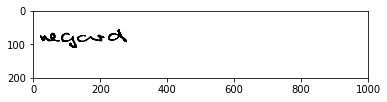

  'regard' -> 'mederd<STOP>'
  Batch: 20 Loss: 0.8817417040774747
100


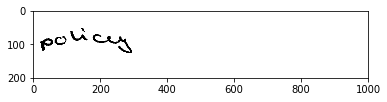

  'policy' -> 'poiced<STOP>'


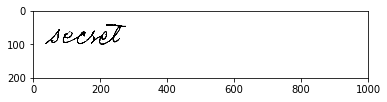

  'secret' -> 'seatce<STOP>'


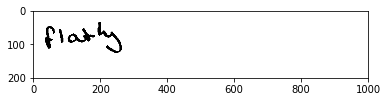

  'flatly' -> 'flatiy<STOP>'
  Batch: 40 Loss: 0.59109711205402
100


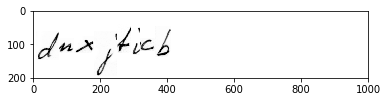

  'dnxjticb' -> 'dnxjticb<STOP>'


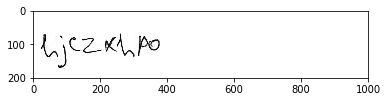

  'hjczxhpo' -> 'hjczxhpn<STOP>'


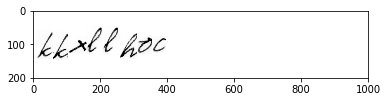

  'kkxllhoc' -> 'kkxllhoc<STOP>'
  Batch: 60 Loss: 0.3707510685069221
Test loss: 0.562227
Training epoch 5...
  Batch: 30 Loss: 0.11106878001361141
  Batch: 60 Loss: 0.10726639003300714
  Batch: 90 Loss: 0.16064323949356557
  Batch: 120 Loss: 0.14324753511007185
  Batch: 150 Loss: 0.12518504730627808
  Batch: 180 Loss: 0.09259593239586268
  Batch: 210 Loss: 0.1191720279509192
  Batch: 240 Loss: 0.11197917476720202
  Batch: 270 Loss: 0.10848714478382909
  Batch: 300 Loss: 0.11697354862978929
  Batch: 330 Loss: 0.14229036376826346
  Batch: 360 Loss: 0.1288034905341488
  Batch: 390 Loss: 0.1176281236513227
  Batch: 420 Loss: 0.11121117923270774
  Batch: 450 Loss: 0.10124701759127515
  Batch: 480 Loss: 0.10669625650785826
  Batch: 510 Loss: 0.12537385801789622
  Batch: 540 Loss: 0.11634677904308159
  Batch: 570 Loss: 0.11034315017342726
  Batch: 600 Loss: 0.1122225080655208
  Batch: 630 Loss: 0.10134075858250811
  Batch: 660 Loss: 0.1162545402667352
Train loss: 0.116879
Discr applied 0 tim

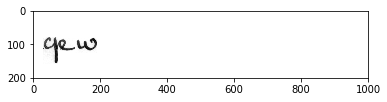

  'qew' -> 'qew<STOP>'


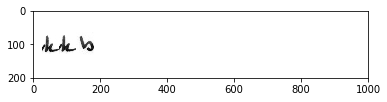

  'kkb' -> 'kkb<STOP>'


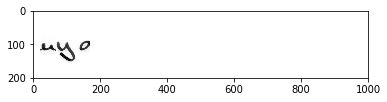

  'nyo' -> 'nyo<STOP>'
  Batch: 20 Loss: 0.7479315525013214
100


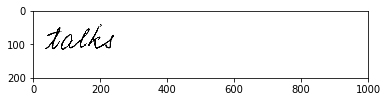

  'talks' -> 'balks<STOP>'


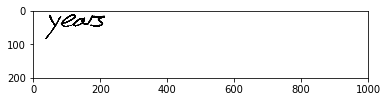

  'years' -> 'yeare<STOP>'


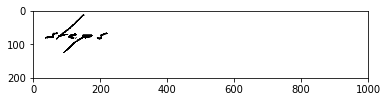

  'steps' -> 'staps<STOP>'
  Batch: 40 Loss: 0.600263914598359
100


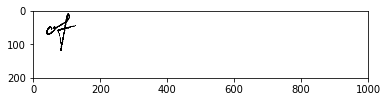

  'of' -> 'of<STOP>'


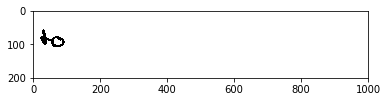

  'to' -> 'to<STOP>'


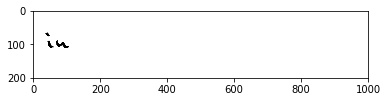

  'in' -> 'in<STOP>'
  Batch: 60 Loss: 0.5912116742444536
Test loss: 0.626470
Training epoch 6...
  Batch: 30 Loss: 0.12348680381342848
  Batch: 60 Loss: 0.11697657024320313
  Batch: 90 Loss: 0.11363412489409917
  Batch: 120 Loss: 0.12382596085242258
  Batch: 150 Loss: 0.09592110768891875
  Batch: 180 Loss: 0.09082267891605773
  Batch: 210 Loss: 0.08452596245781967
  Batch: 240 Loss: 0.1345480686791793
  Batch: 270 Loss: 0.13008986529012126
  Batch: 300 Loss: 0.1047914928066293
  Batch: 330 Loss: 0.14273806086549212
  Batch: 360 Loss: 0.11747857396761893
  Batch: 390 Loss: 0.11374428027107443
  Batch: 420 Loss: 0.13500568499276167
  Batch: 450 Loss: 0.08858173029334654
  Batch: 480 Loss: 0.11736978169983973
  Batch: 510 Loss: 0.1496159844869186
  Batch: 540 Loss: 0.09574849204012445
  Batch: 570 Loss: 0.09641014723087508
  Batch: 600 Loss: 0.09232229197974359
  Batch: 630 Loss: 0.0849595489911735
  Batch: 660 Loss: 0.10540118966857709
Train loss: 0.110701
Discr applied 0 times.
Testing

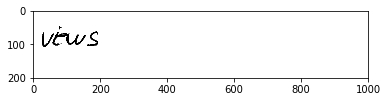

  'views' -> 'bears<STOP>'


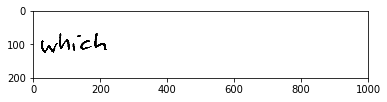

  'which' -> 'which<STOP>'


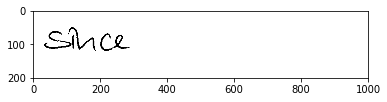

  'since' -> 'shric<STOP>'
  Batch: 20 Loss: 0.8575152138144606
100


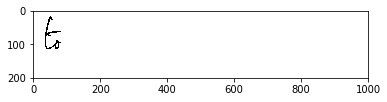

  'to' -> 'to<STOP>'


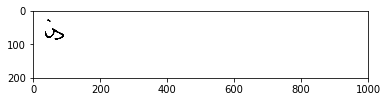

  'is' -> 'is<STOP>'


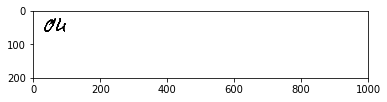

  'on' -> 'on<STOP>'
  Batch: 40 Loss: 0.4084615092054896
100


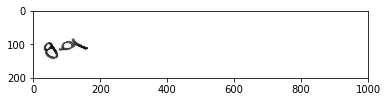

  'gd' -> 'gd<STOP>'


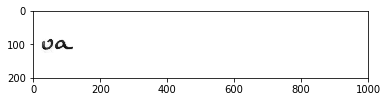

  'va' -> 'va<STOP>'


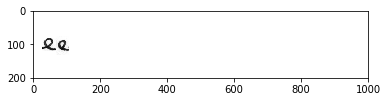

  'ee' -> 'ee<STOP>'
  Batch: 60 Loss: 0.5472424733972857
Test loss: 0.580142
Training epoch 7...
  Batch: 30 Loss: 0.12476599639454097
  Batch: 60 Loss: 0.11900796594369233
  Batch: 90 Loss: 0.133808519021465
  Batch: 120 Loss: 0.1261810966467278
  Batch: 150 Loss: 0.10722931598367354
  Batch: 180 Loss: 0.12568939917656793
  Batch: 210 Loss: 0.09629560229018642
  Batch: 240 Loss: 0.1386538872213433
  Batch: 270 Loss: 0.13242348077261043
  Batch: 300 Loss: 0.1067626981057286
  Batch: 330 Loss: 0.11065058762991123
  Batch: 360 Loss: 0.14176719759526865
  Batch: 390 Loss: 0.12484812878956773
  Batch: 420 Loss: 0.11794348648537403
  Batch: 450 Loss: 0.08538472068902578
  Batch: 480 Loss: 0.11965366803700962
  Batch: 510 Loss: 0.07402728330713534
  Batch: 540 Loss: 0.10401241990308913
  Batch: 570 Loss: 0.13397033430631003
  Batch: 600 Loss: 0.08135090152008666
  Batch: 630 Loss: 0.09967714909207884
  Batch: 660 Loss: 0.09388220348291927
Train loss: 0.113005
Discr applied 0 times.
Testing.

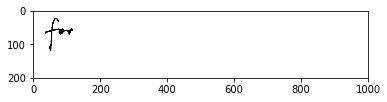

  'for' -> 'for<STOP>'


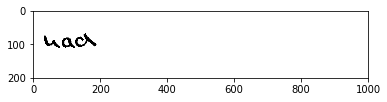

  'had' -> 'had<STOP>'


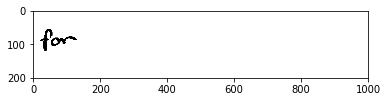

  'for' -> 'for<STOP>'
  Batch: 20 Loss: 0.806412980889399
100


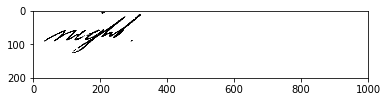

  'night' -> 'wasit<STOP>'


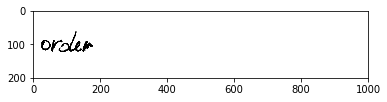

  'order' -> 'order<STOP>'


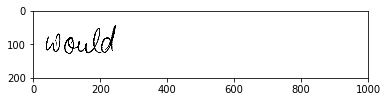

  'would' -> 'would<STOP>'
  Batch: 40 Loss: 0.5286597631661782
100


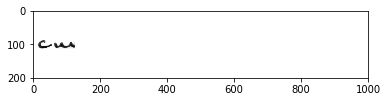

  'cm' -> 'cm<STOP>'


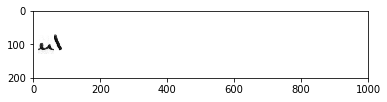

  'nl' -> 'nl<STOP>'


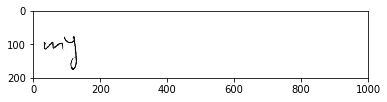

  'my' -> 'my<STOP>'
  Batch: 60 Loss: 0.5130843157626482
Test loss: 0.570994
Training epoch 8...


KeyboardInterrupt: ignored

In [56]:
for i in range(0, 100):
  max_size = 8
  prob = 0.3
  randx=20
  train(i, max_size, False, prob, randx)
  test(max_size, prob, randx)


In [0]:
for i in range(0, 7):
  max_size = 1
  prob = 1
  train(i, max_size, True, prob)
  test(max_size, prob)

In [0]:
for i in range(0, 10):
  max_size = 3
  prob = 1
  train(i, max_size, True, prob)
  test(max_size, prob)

In [0]:
for i in range(0, 100):
  if i %3 == 0:
    state_dict = {
        "encoder": encoder.state_dict(),
        "encoder_optimizer": encoder_optimizer.state_dict(),
        "decoder": decoder.state_dict(),
        "decoder_optimizer": decoder_optimizer.state_dict(),
        "discriminator": discriminator.state_dict(),
        "discriminator_optimizer": discriminator_optimizer.state_dict(),
      }

    torch.save(state_dict, file_name)
    print("Network saved")
  max_size = 8
  prob = 0.5
  train(i, max_size, False, prob)
  test(max_size, prob)

In [0]:
for i in range(0, 100):
  max_size = 6
  train(i, max_size, True)
  test(max_size)

In [0]:
test(1)

In [0]:
# state_dict = {
#         "encoder": encoder.state_dict(),
#         "encoder_optimizer": encoder_optimizer.state_dict(),
#         "decoder": decoder.state_dict(),
#         "decoder_optimizer": decoder_optimizer.state_dict(),
#         "discriminator": discriminator.state_dict(),
#         "discriminator_optimizer": discriminator_optimizer.state_dict(),
#       }

# torch.save(state_dict, file_name)


In [0]:
test(2)

In [0]:
data, target = artificial_data.make_random_batch(3, 200)

In [0]:
for i in range(0, 30):
  plt.imshow(data[i])
  plt.show()
  print(test_set.decode_word(target[i]))

In [0]:
test(2, 1 )

In [0]:
def restore_net(file_name):
  state = torch.load(file_name)
  encoder.load_state_dict(state["encoder"])
  encoder_optimizer.load_state_dict(state["encoder_optimizer"])
  decoder.load_state_dict(state["decoder"])
  decoder_optimizer.load_state_dict(state["decoder_optimizer"])
  discriminator.load_state_dict(state["discriminator"])
  discriminator_optimizer.load_state_dict(state["discriminator_optimizer"])

In [0]:
#save_net("/gdrive/My Drive/unif_8_6.tar")

Network saved: /gdrive/My Drive/unif_8_6.tar
